gen	nevals	avg    	min	max 
0  	0     	770.648	600	1100
1  	405   	877.13 	600	1100
gen	nevals	avg   	min	max 
0  	0     	877.13	600	1100
1  	406   	945.024	600	1100
gen	nevals	avg    	min	max 
0  	0     	945.024	600	1100
1  	404   	984.016	600	1100
gen	nevals	avg    	min	max 
0  	0     	984.016	600	1100
1  	408   	1023.5 	600	1100
gen	nevals	avg   	min	max 
0  	0     	1023.5	600	1100
1  	386   	1026  	600	1100
gen	nevals	avg 	min	max 
0  	0     	1026	600	1100
1  	395   	1024	600	1100
gen	nevals	avg 	min	max 
0  	0     	1024	600	1100
1  	406   	1028.04	600	1100
gen	nevals	avg    	min	max 
0  	0     	1028.04	600	1100
1  	398   	1026.45	600	1100
gen	nevals	avg    	min	max 
0  	0     	1026.45	600	1100
1  	393   	1029.03	600	1100
gen	nevals	avg    	min	max 
0  	0     	1029.03	600	1100
1  	392   	1025.62	600	1100
gen	nevals	avg    	min	max 
0  	0     	1025.62	600	1100
1  	390   	1035.67	600	1100
gen	nevals	avg    	min	max 
0  	0     	1035.67	600	1100
1  	404   	1014.44	600	1100
gen	nevals	a

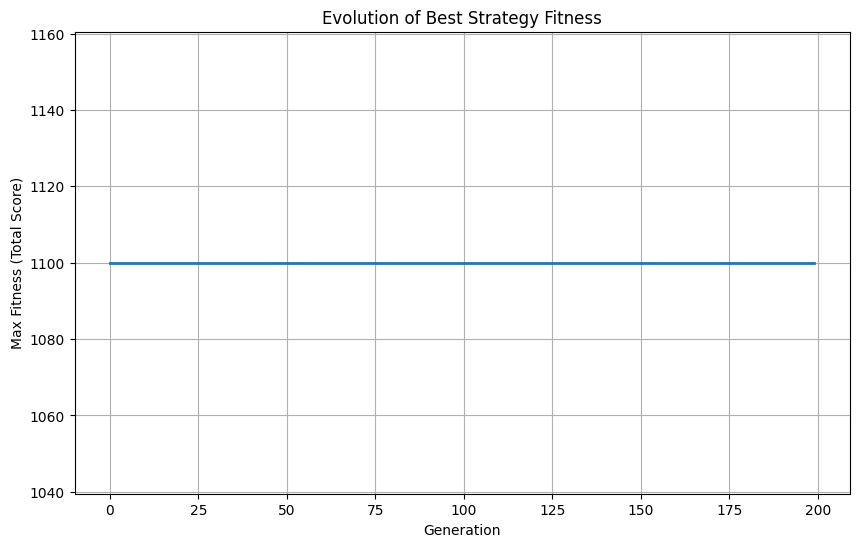

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# game configuration
HISTORY_LENGTH = 2           # number of past moves to consider
GENOME_LENGTH = 2 ** (2 * HISTORY_LENGTH)  # 16 for HISTORY_LENGTH=2
NUM_ROUNDS = 100            # number of rounds per IPD game

# genetic algorithm parameters
POPULATION_SIZE = 500       # number of individuals in population
MUTATION_RATE = 0.3         # probability of mutation
CROSSOVER_RATE = 0.7        # probability of crossover
TOURNAMENT_SIZE = 3         # size of tournament selection
ELITISM_SIZE = 10           # number of best individuals to keep
MAX_GENERATIONS = 200       # number of generations to run

# clear existing deap classes to avoid conflicts
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# create deap fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# IPD payoff matrix: (C,C)=3,3; (D,D)=1,1; (C,D)=0,5; (D,C)=5,0
PAYOFF = {
    (0, 0): (3, 3),  # both cooperate
    (0, 1): (0, 5),  # agent cooperates, opponent defects
    (1, 0): (5, 0),  # agent defects, opponent cooperates
    (1, 1): (1, 1)   # both defect
}

# opponent strategies
def all_cooperate(history_self, history_opponent):
    return 0  # always cooperate

def all_defect(history_self, history_opponent):
    return 1  # always defect

def tit_for_tat(history_self, history_opponent):
    return history_opponent[-1] if history_opponent else 0  # copy opponent's last move, cooperate first

OPPONENTS = [
    ("ALLC", all_cooperate),
    ("ALLD", all_defect),
    ("TFT", tit_for_tat)
]

def history_to_index(history_self, history_opponent):
    # convert last HISTORY_LENGTH moves to binary index
    index = 0
    for i in range(HISTORY_LENGTH):
        if i < len(history_self):
            index = (index << 1) | history_self[-i-1]
        else:
            index = index << 1
        if i < len(history_opponent):
            index = (index << 1) | history_opponent[-i-1]
        else:
            index = index << 1
    return index

def play_ipd(strategy_genome, opponent_strategy):
    # play IPD for NUM_ROUNDS, return agent's score
    history_self = []
    history_opponent = []
    score = 0
    for _ in range(NUM_ROUNDS):
        # get agent's move from genome
        state_index = history_to_index(history_self, history_opponent)
        move_self = strategy_genome[state_index]
        # get opponent's move
        move_opponent = opponent_strategy(history_self, history_opponent)
        # update score
        score += PAYOFF[(move_self, move_opponent)][0]
        # update histories
        history_self.append(move_self)
        history_opponent.append(move_opponent)
    return score

def evaluate_strategy(individual):
    # evaluate genome against all opponents
    total_score = 0
    for _, opponent_strategy in OPPONENTS:
        total_score += play_ipd(individual, opponent_strategy)
    return total_score,

# initialize deap toolbox
toolbox = base.Toolbox()

# register functions for generating genes, individuals, and population
toolbox.register("gene_maker", random.randint, 0, 1)
toolbox.register("individual_creator", tools.initRepeat, creator.Individual, 
                 toolbox.gene_maker, n=GENOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual_creator)

# register genetic algorithm operators
toolbox.register("evaluate", evaluate_strategy)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=MUTATION_RATE)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
toolbox.register("elitism", tools.selBest, k=ELITISM_SIZE)

# initialize statistics tracking
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)  # track average fitness
stats.register("min", np.min)   # track minimum fitness
stats.register("max", np.max)   # track maximum fitness

if __name__ == "__main__":
    # create initial population
    population = toolbox.population(n=POPULATION_SIZE)
    
    # evaluate fitness for all individuals
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # create hall of fame to store top individuals
    hof = tools.HallOfFame(ELITISM_SIZE)
    
    # track fitness history for plotting
    fitness_history = []

    # run genetic algorithm
    for gen in range(MAX_GENERATIONS):
        population, _ = algorithms.eaSimple(population, 
                                        toolbox,
                                        cxpb=CROSSOVER_RATE,
                                        mutpb=MUTATION_RATE,
                                        ngen=1,
                                        stats=stats,
                                        halloffame=hof,
                                        verbose=True)
        # record max fitness for this generation
        max_fitness = max(ind.fitness.values[0] for ind in population)
        fitness_history.append(max_fitness)
    
    # extract best individual
    best_individual = tools.selBest(population, 1)[0]

    # print results
    print("Best strategy genome:", best_individual)
    print("Fitness value:", best_individual.fitness.values[0])

    # implement zrada function based on best genome
    def zrada(moje_historie, protihracova_historie):
        state_index = history_to_index(moje_historie, protihracova_historie)
        return best_individual[state_index]

    # plot fitness evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(MAX_GENERATIONS), fitness_history, linewidth=2)
    plt.xlabel('Generation')
    plt.ylabel('Max Fitness (Total Score)')
    plt.title('Evolution of Best Strategy Fitness')
    plt.grid(True)
    plt.show()